Get dataframe

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('../song_features.csv')
df.head()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genres
0,0HZk0QsXPhMNAWNDR3rYE8,0.4700,0.364,0.378,0.0,7,0.3390,-7.381,0,0.0331,89.918,3,0.366,a-cappella
1,6tkbKjaHRL2ZG5wtmHzXgn,0.7640,0.556,0.412,0.0,7,0.0902,-10.224,1,0.0992,84.778,4,0.811,a-cappella
2,4z8sz6E4YyFuEkv5o7IJni,0.3020,0.497,0.312,0.0,11,0.0968,-9.088,0,0.0269,105.036,4,0.177,a-cappella
3,6XamqE26MOlAoXs1LZr8AU,0.3080,0.674,0.517,0.0,2,0.0896,-7.147,1,0.0555,120.127,4,0.476,a-cappella
4,5glU2EWqa5hpYqGPboSNjV,0.0243,0.419,0.817,0.0,2,0.2510,-4.704,1,0.0468,78.107,4,0.317,a-cappella


Histogram

array([[<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>],
       [<AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'liveness'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'speechiness'}>,
        <AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'valence'}>]], dtype=object)

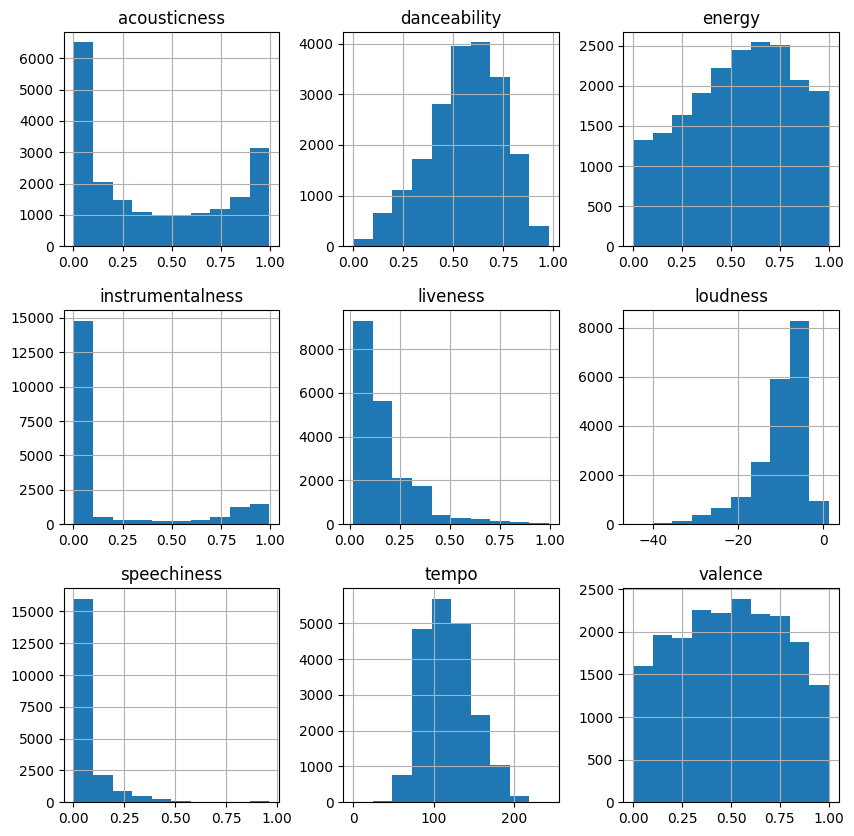

In [80]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df[features].hist(figsize=(10,10))

Heatmap

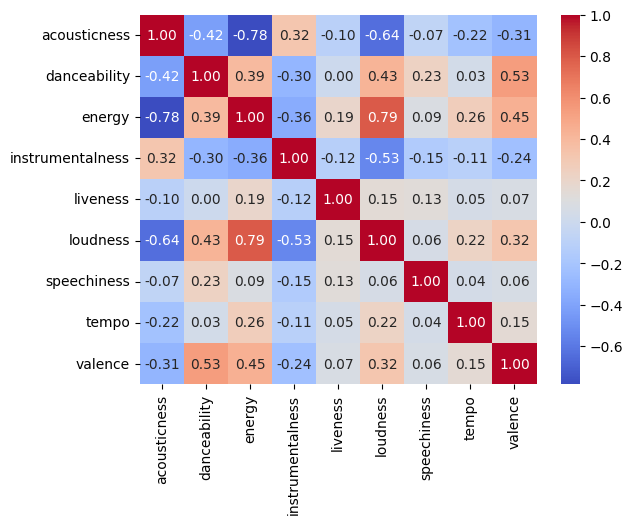

In [41]:
import seaborn as sns
dataplot = sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap='coolwarm')

Box plot for features

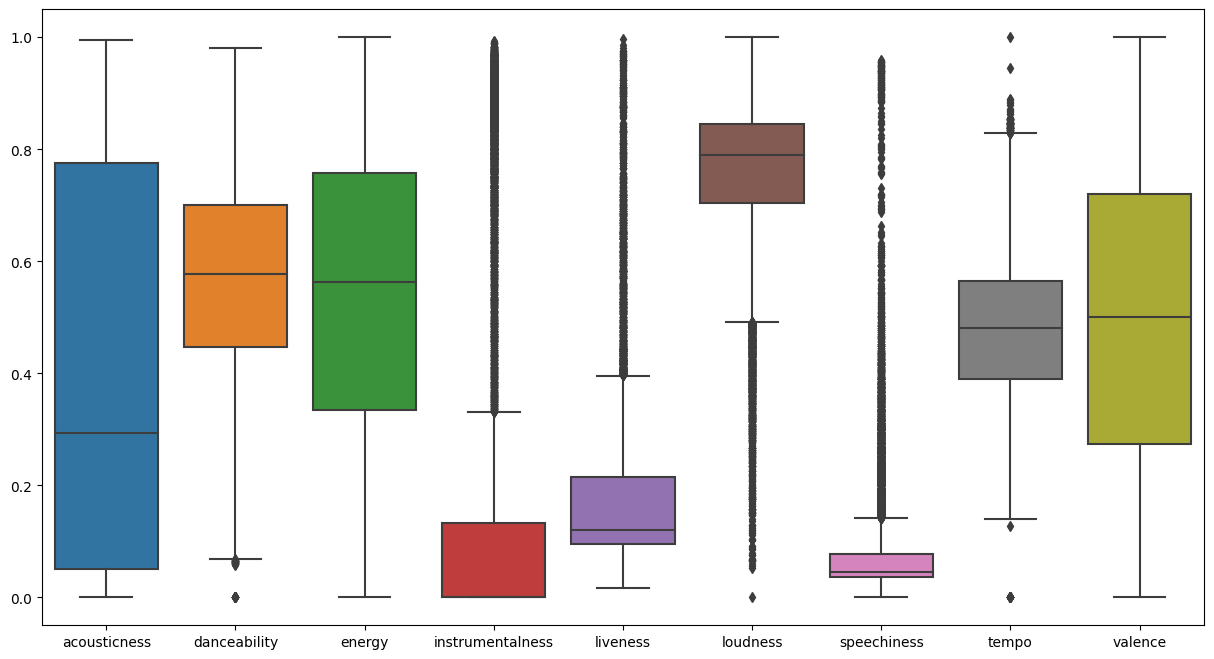

In [37]:

# Scale tempo and loudness to [0, 1]
temp = df.copy(deep=True)
for col in ['loudness', 'tempo']:
    temp[col] = ((temp[col] - temp[col].min()) / (temp[col].max() - temp[col].min()))
sns.boxplot(data=temp[features])
# Resize plot
plt.gcf().set_size_inches(15, 8)
plt.show()

Remove outliers

In [55]:
# Remove any data with tempo = 0
no_out_df = df[df['tempo'] != 0]
# Remove any data with time_signature = 0
no_out_df = no_out_df[no_out_df['time_signature'] != 0]
# Remove key, genres, id
no_out_df = no_out_df.drop(['key', 'id'], axis=1)
# Subset data to include only 500 songs per genre
sub_df = []
for genre in no_out_df['genres'].unique():
    sub_df.append(no_out_df[no_out_df['genres'] == genre].sample(500, random_state=1))
sub_df = pd.concat(sub_df)
sub_df.drop('genres', axis=1, inplace=True)
sub_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
10007,0.949,0.214,0.0803,0.000008,0.0974,-16.464,1,0.0388,115.816,1,0.124
10109,0.320,0.559,0.6250,0.000000,0.0399,-5.101,1,0.0493,132.078,4,0.646
452,0.763,0.268,0.1710,0.000000,0.0685,-7.368,1,0.0294,104.639,4,0.253
368,0.935,0.155,0.1880,0.000000,0.1040,-12.075,1,0.0398,79.287,4,0.144
242,0.336,0.431,0.5440,0.000111,0.5290,-8.796,1,0.0310,87.995,4,0.409


Scale data

In [70]:
from sklearn.preprocessing import MinMaxScaler
# Scale tempo and loudness to [0, 1] using min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = sub_df.copy(deep=True)
scaled_df[['loudness', 'tempo']] = scaler.fit_transform(scaled_df[['loudness', 'tempo']])
# Rescale time_signature to [0, 1] but counts in the frequency of each time signature
freq = scaled_df['time_signature'].value_counts(normalize=True)
scaled_df['time_signature'] = scaled_df['time_signature'].apply(lambda x: freq[x])
scaled_df.head()


,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,clusters
10007,0.949,0.214,0.0803,0.000008,0.0974,0.592680,1,0.0388,0.411616,0.0111,0.124,2
10109,0.320,0.559,0.6250,0.000000,0.0399,0.852614,1,0.0493,0.495404,0.8614,0.646,0
452,0.763,0.268,0.1710,0.000000,0.0685,0.800755,1,0.0294,0.354027,0.8614,0.253,0
368,0.935,0.155,0.1880,0.000000,0.1040,0.693080,1,0.0398,0.223403,0.8614,0.144,0
242,0.336,0.431,0.5440,0.000111,0.5290,0.768089,1,0.0310,0.268270,0.8614,0.409,0


Clustering with Hierachical Clustering

In [71]:
import gower
from sklearn.cluster import AgglomerativeClustering
distance_matrix = gower.gower_matrix(scaled_df)
distance_matrix

array([[0.        , 0.34664688, 0.20321809, ..., 0.3673239 , 0.39602086,
        0.40348053],
       [0.34664688, 0.        , 0.15469745, ..., 0.190217  , 0.16852604,
        0.3318973 ],
       [0.20321809, 0.15469745, 0.        , ..., 0.21421684, 0.22477902,
        0.2974414 ],
       ...,
       [0.3673239 , 0.190217  , 0.21421684, ..., 0.        , 0.07044423,
        0.17820965],
       [0.39602086, 0.16852604, 0.22477902, ..., 0.07044423, 0.        ,
        0.21352854],
       [0.40348053, 0.3318973 , 0.2974414 , ..., 0.17820965, 0.21352854,
        0.        ]], dtype=float32)

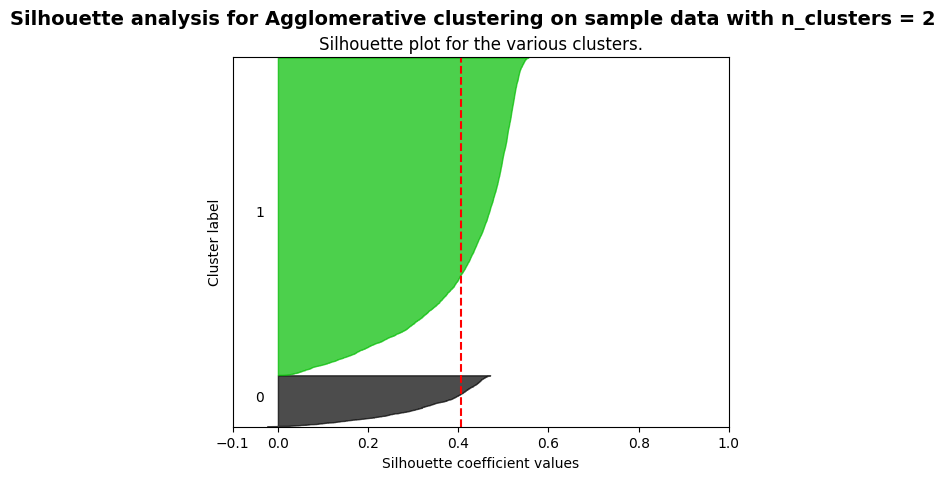

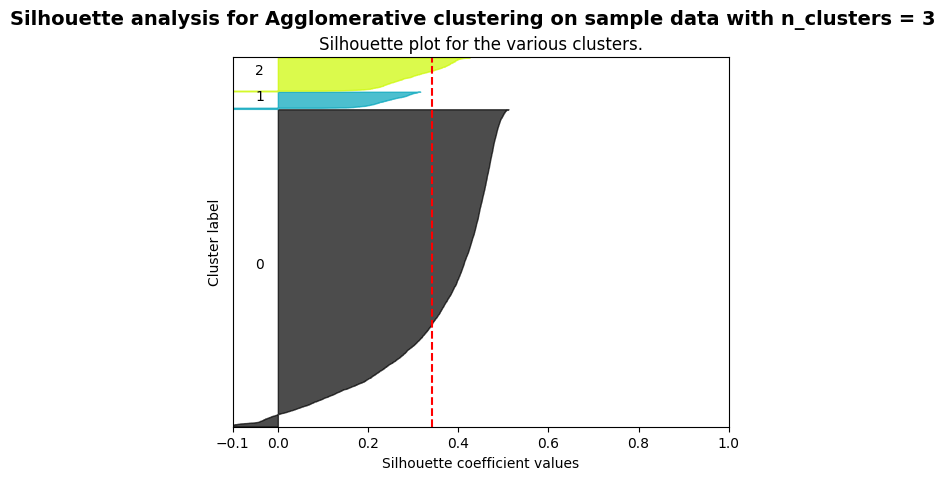

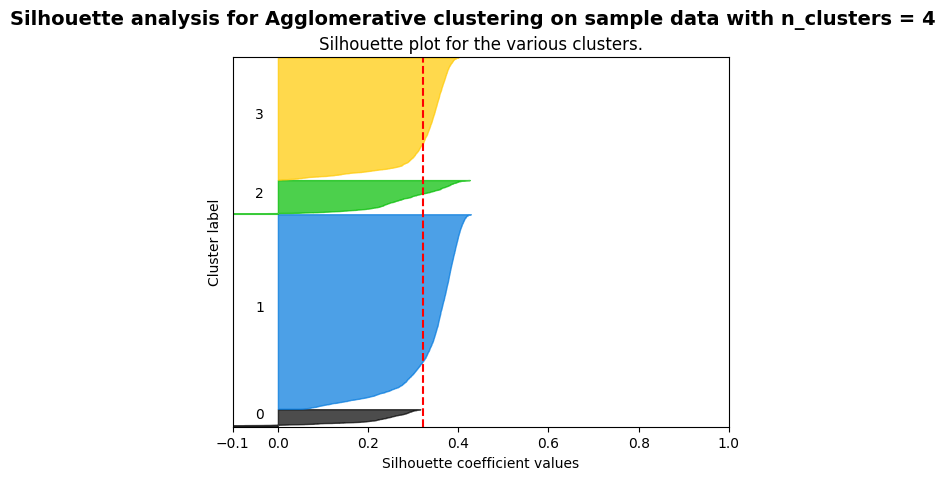

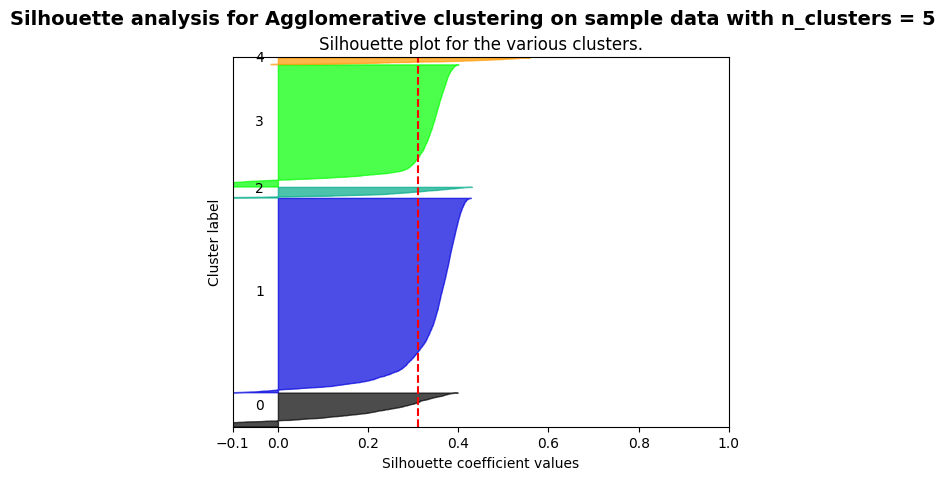

In [98]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Find the best number of clusters by plotting a graph of silhouette score
k_cand = range(2, 6)
for k in k_cand:
    plt.xlim((-0.1, 1.0))
    plt.ylim((0, len(distance_matrix) + (k + 1) * 10))
    model = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=k)
    clusters = model.fit_predict(distance_matrix)
    score = silhouette_score(distance_matrix, clusters, metric='precomputed')
    samples = silhouette_samples(distance_matrix, clusters, metric='precomputed')
    y_lower = 10
    for i in range(k):
        ith_cluster_sil_values = samples[clusters == i]
        ith_cluster_sil_values.sort()
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.axvline(x=score, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title("Silhouette plot for the various clusters.")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.suptitle(("Silhouette analysis for Agglomerative clustering on sample data "
                    "with n_clusters = %d" % k), fontsize=14, fontweight='bold')
    plt.show()


In [76]:
model = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=2)
clusters = model.fit_predict(distance_matrix)
sub_df['clusters'] = clusters
sub_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,clusters
10007,0.949,0.214,0.0803,0.000008,0.0974,-16.464,1,0.0388,115.816,1,0.124,0
10109,0.320,0.559,0.6250,0.000000,0.0399,-5.101,1,0.0493,132.078,4,0.646,1
452,0.763,0.268,0.1710,0.000000,0.0685,-7.368,1,0.0294,104.639,4,0.253,1
368,0.935,0.155,0.1880,0.000000,0.1040,-12.075,1,0.0398,79.287,4,0.144,1
242,0.336,0.431,0.5440,0.000111,0.5290,-8.796,1,0.0310,87.995,4,0.409,1


Investigate the clusters

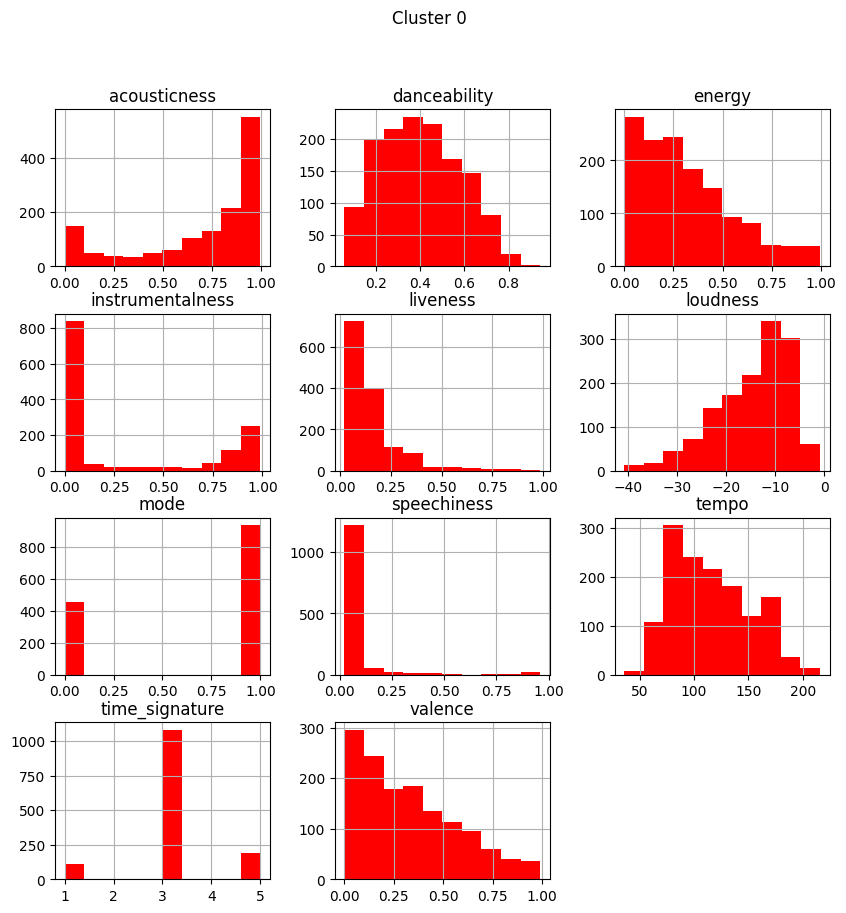

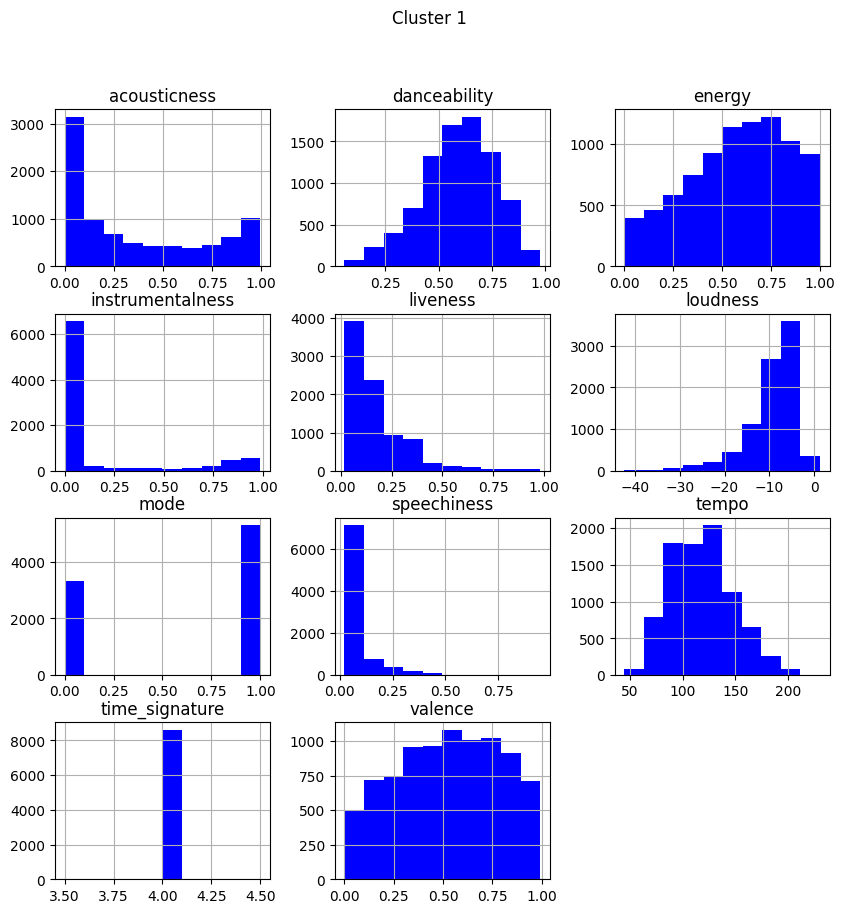

In [78]:
# Plot histogram for each feature in each cluster
plot_features = sub_df.drop(['clusters'], axis=1).columns
for k in range(0, 2):
    color = ['red', 'blue']
    sub_df[sub_df['clusters'] == k][plot_features].hist(figsize=(10,10), color=color[k])
    plt.suptitle('Cluster ' + str(k))

Investigate the difference between clusters

In [10]:
# TODO

Approach #2: Clustering using K-medoids

In [86]:
#import kmedoids
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

mhv = pdist(scaled_df, 'cityblock')
mh = squareform(mhv,force='tomatrix')
pd.DataFrame(mh[:3,:3])

,0,1,2
0,0.000000,5.302730,3.613971
1,5.302730,0.000000,1.822736
2,3.613971,1.822736,0.000000


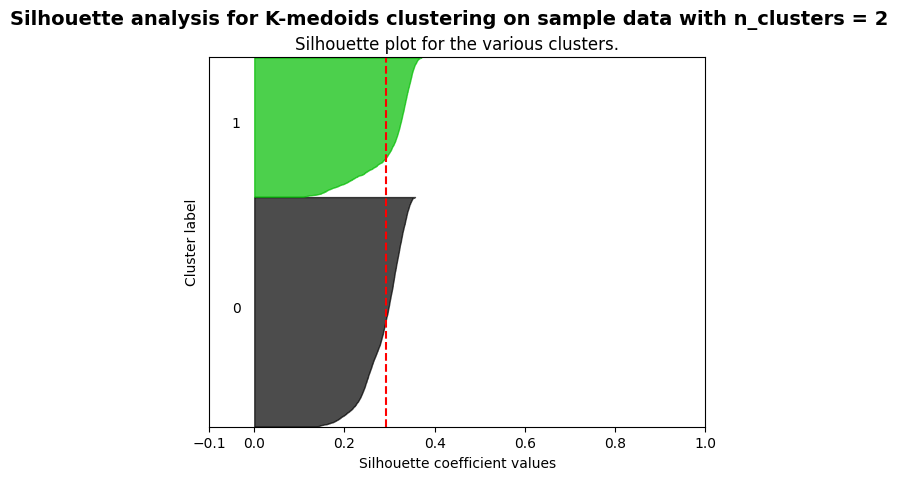

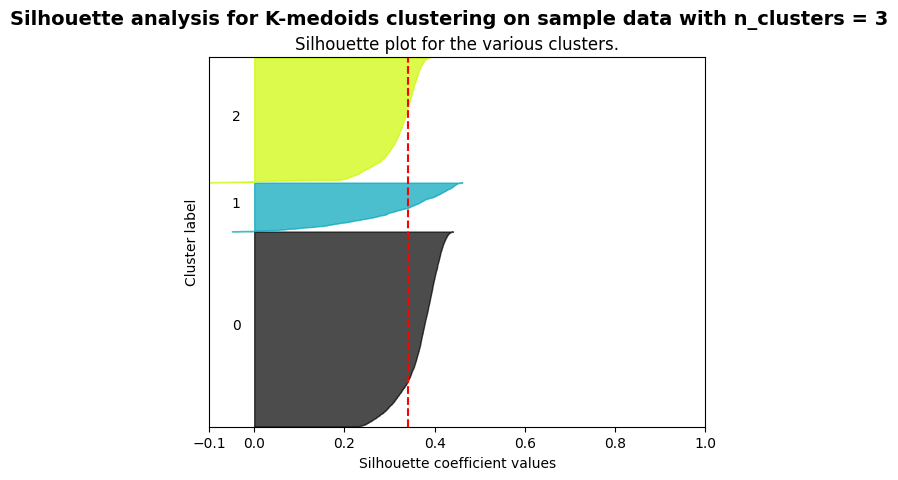

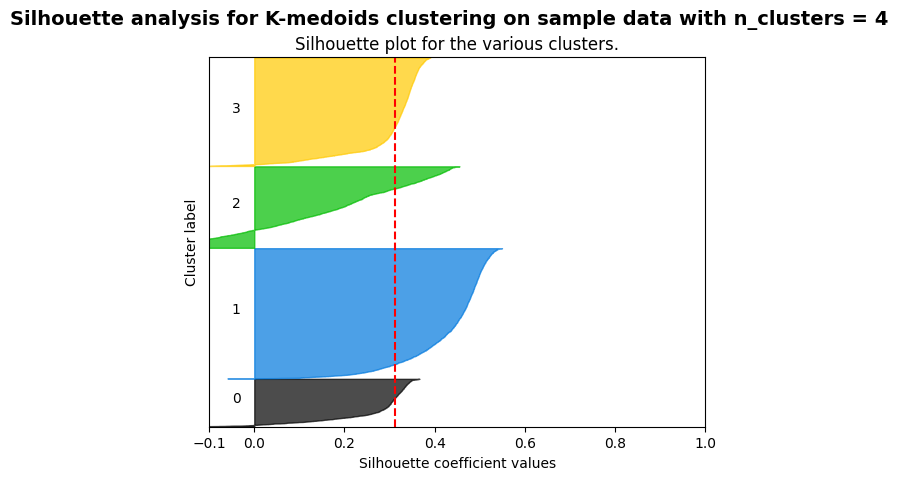

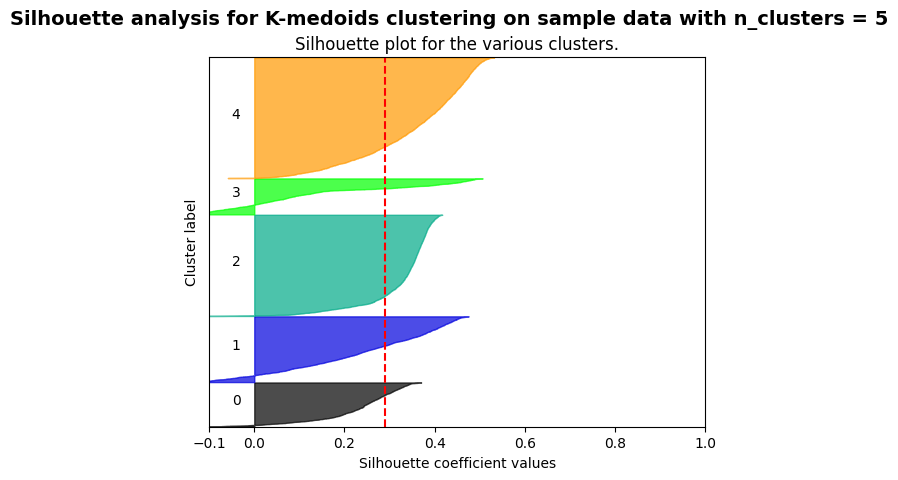

In [100]:
k_cand = range(2, 6)

for k in k_cand:
    plt.xlim((-0.1, 1.0))
    plt.ylim((0, len(mh) + (k + 1) * 10))
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,1000,size=k)
    kmedoids_instance = kmedoids(mh, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output to "standard" output
    clusters = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    # score
    score = silhouette_score(mh, clusters, metric='precomputed')
    samples = silhouette_samples(mh, clusters, metric='precomputed')
    y_lower = 10
    for i in range(k):
        ith_cluster_sil_values = samples[clusters == i]
        ith_cluster_sil_values.sort()
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.axvline(x=score, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title("Silhouette plot for the various clusters.")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.suptitle(("Silhouette analysis for K-medoids clustering on sample data "
                    "with n_clusters = %d" % k), fontsize=14, fontweight='bold')
    plt.show()
    

In [ ]:
initial_medoids = np.random.randint(0,1000,size=2)
kmedoids_instance = kmedoids(mh, initial_medoids, data_type='distance_matrix')    

# run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# convert cluster output to "standard" output
clusters = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
sub_df['clusters'] = clusters
sub_df.head()

In [ ]:
# Plot histogram for each feature in each cluster
plot_features = sub_df.drop(['clusters'], axis=1).columns
for k in range(0, 2):
    color = ['red', 'blue']
    sub_df[sub_df['clusters'] == k][plot_features].hist(figsize=(10,10), color=color[k])
    plt.suptitle('Cluster ' + str(k))